In [1]:
.libPaths(R.home('/opt/homebrew/Caskroom/miniforge/base/lib/R/library'))
Output = '/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1013. Microbiome Peanut Allergy/P1013.3. Analyses/P1013.3.3. Volcano Plots/Output'
cur_date = '022326'

library(readxl)
library(openxlsx)
library(writexl)
library(tidyverse)
library(ggrepel)
library(ggsci)

# reading in files
bl_saliva_adj = data.frame(Model = '(A) Outcome Comparison in Saliva Pre Treatment', read_excel("Input/Saliva_Adj_Pre_Outcome_012026.xlsx")) %>%
    select(-Original_Name)
bl_stool_adj = data.frame(Model = '(A) Outcome Comparison in Stool Pre Treatment', read_excel("Input/Stool_Adj_Pre_Outcome_012026.xlsx")) %>%
    select(-Original_Name)
post_saliva_adj = data.frame(Model = '(B) Outcome Comparison in Saliva Post Treatment', read_excel("Input/Saliva_Adj_Post_Outcome_012026.xlsx")) %>%
    select(-Original_Name)
post_stool_adj = data.frame(Model = '(B) Outcome Comparison in Stool Post Treatment', read_excel("Input/Stool_Adj_Post_Outcome_012026.xlsx")) %>%
    select(-Original_Name)
paired_saliva_adj = data.frame(Model = '(A) Time Point Comparison in Paired Saliva Samples', read_excel("Input/Saliva_Adj_Paired_012026.xlsx")) %>%
    select(-Original_Name)
paired_stool_adj = data.frame(Model = '(B) Time Point Comparison in Paired Stool Samples', read_excel("Input/Stool_Adj_Paired_012026.xlsx")) %>%
    select(-Original_Name)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
head(bl_saliva_adj)

,Model,Name,logFC,P.Value,P.Adj,Sensitivity.Analysis,diff_robust_OutcomeSU
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
1,(A) Outcome Comparison in Saliva Pre Treatment,Unassigned,0.6735441,0.1626136,0.3542723,TRUE,FALSE
2,(A) Outcome Comparison in Saliva Pre Treatment,Absconditabacteria_.SR1._.G.1. bacterium_HMT_874,0.6116691,0.1575635,0.3534533,TRUE,FALSE
3,(A) Outcome Comparison in Saliva Pre Treatment,Actinomyces,0.9036849,0.0405009,0.1747103,TRUE,FALSE
4,(A) Outcome Comparison in Saliva Pre Treatment,Actinomyces graevenitzii,-0.7811848,0.2593095,0.4483893,TRUE,FALSE
5,(A) Outcome Comparison in Saliva Pre Treatment,Schaalia lingnae,-0.5491409,0.1104903,0.2778999,TRUE,FALSE
6,(A) Outcome Comparison in Saliva Pre Treatment,Schaalia HMT_180,-0.4392805,0.3063656,0.4985949,TRUE,FALSE


Creating a volcano plot to visualize bacteria that were differentially abundant.

In [3]:
# combining dfs
baseline_adj_df = rbind(bl_saliva_adj, bl_stool_adj) %>%
        # convert log fc to log2 fc
        mutate(log2FC = log2(10^logFC),
             Sensitivity.Analysis = ifelse(Sensitivity.Analysis == TRUE, "Passed", "Failed")) %>% 
        select(-logFC)
post_adj_df = rbind(post_saliva_adj, post_stool_adj) %>%
        mutate(log2FC = log2(10^logFC),
             Sensitivity.Analysis = ifelse(Sensitivity.Analysis == TRUE, "Passed", "Failed")) %>% 
        select(-logFC)
paired_adj_df = rbind(paired_saliva_adj, paired_stool_adj) %>%
        mutate(log2FC = log2(10^logFC),
             Sensitivity.Analysis = ifelse(Sensitivity.Analysis == TRUE, "Passed", "Failed")) %>% 
        select(-logFC)

In [4]:
get_significance = function(df){
    # adding a col to denote whether a Name1 had a significant p value, log FC, or both
    
    # add a column of NAs
    df$diffexpressed <- "No Significance"
    
    # if p adj is significant only
    df$diffexpressed[df$P.Adj < 0.1] <- "P Adjust Only"
    
    # if logFoldChange > log(1.5) and p adj < 0.1, set as "significant" 
    df$diffexpressed[abs(df$log2FC) > log2(1.5) & df$P.Adj < 0.1] <- "Positive"
    df$diffexpressed[df$log2FC < -log2(1.5) & df$P.Adj < 0.1] <- "Negative"
    
    # making into a factor
    df$diffexpressed = factor(df$diffexpressed, levels = c("No Significance", "P Adjust Only", 
                                                                           "Positive", "Negative"))

    return(df)
}

# calling fn
sig_baseline_adj_df = get_significance(baseline_adj_df)
sig_post_adj_df = get_significance(post_adj_df)
sig_paired_adj_df = get_significance(paired_adj_df)

In [5]:
# identifying genes commonly modulated across exposure groups to label them differently
sig_bl_saliva_bacteria = sig_baseline_adj_df %>%
    filter(Model == '(A) Outcome Comparison in Saliva Pre Treatment', diffexpressed %in% c("Positive", "Negative")) %>%
    select(Name) %>% pull()

sig_bl_stool_bacteria = sig_baseline_adj_df %>%
    filter(Model == '(A) Outcome Comparison in Stool Pre Treatment', diffexpressed %in% c("Positive", "Negative")) %>%
    select(Name) %>% pull()

sig_post_saliva_bacteria = sig_post_adj_df %>%
    filter(Model == '(B) Outcome Comparison in Saliva Post Treatment', diffexpressed %in% c("Positive", "Negative")) %>%
    select(Name) %>% pull()

sig_post_stool_bacteria = sig_post_adj_df %>%
    filter(Model == '(B) Outcome Comparison in Stool Post Treatment', diffexpressed %in% c("Positive", "Negative")) %>%
    select(Name) %>% pull()

sig_paired_saliva_bacteria = sig_paired_adj_df %>%
    filter(Model == '(A) Time Point Comparison in Paired Saliva Samples', diffexpressed %in% c("Positive", "Negative")) %>%
    select(Name) %>% pull()

sig_paired_stool_bacteria = sig_paired_adj_df %>%
    filter(Model == '(B) Time Point Comparison in Paired Stool Samples', diffexpressed %in% c("Positive", "Negative")) %>%
    select(Name) %>% pull()

`%notin%` <- Negate(`%in%`)

# finding bacteria that were significantly different pre and post in saliva
saliva_time_common_bacteria = intersect(sig_bl_saliva_bacteria, sig_post_saliva_bacteria)
saliva_time_uncommon_boolean = c(sig_bl_saliva_bacteria, sig_post_saliva_bacteria) %notin% saliva_time_common_bacteria
saliva_time_uncommon_bacteria = c(sig_bl_saliva_bacteria, sig_post_saliva_bacteria)[saliva_time_uncommon_boolean]

stool_time_common_bacteria = intersect(sig_bl_stool_bacteria, sig_post_stool_bacteria)
stool_time_uncommon_boolean = c(sig_bl_stool_bacteria, sig_post_stool_bacteria) %notin% stool_time_common_bacteria
stool_time_uncommon_bacteria = c(sig_bl_stool_bacteria, sig_post_stool_bacteria)[stool_time_uncommon_boolean]

saliva_paired_common_bacteria = intersect(sig_paired_saliva_bacteria, sig_bl_saliva_bacteria)
saliva_paired_uncommon_boolean = c(sig_paired_saliva_bacteria, sig_bl_saliva_bacteria) %notin% saliva_paired_common_bacteria
saliva_paired_uncommon_bacteria = c(sig_paired_saliva_bacteria, sig_bl_saliva_bacteria)[saliva_paired_common_bacteria]

stool_paired_common_bacteria = intersect(sig_paired_stool_bacteria, sig_bl_stool_bacteria)
stool_paired_uncommon_boolean = c(sig_paired_stool_bacteria, sig_bl_stool_bacteria) %notin% stool_paired_common_bacteria
stool_paired_uncommon_bacteria = c(sig_paired_stool_bacteria, sig_bl_stool_bacteria)[stool_paired_common_bacteria]

What bacteria are still significantly different between outcomes even after treatment?

In [6]:
saliva_time_common_bacteria
stool_time_common_bacteria

character(0)

[1] "Ruminiclostridium siraeum"

Just 1 bacteria in stool samples.

What bacteria were significantly different in this paired analysis that were significantly different across outcomes regardless of time point?

In [7]:
saliva_paired_common_bacteria
stool_paired_common_bacteria

character(0)

character(0)

0 bacteria.

# Volcano Plot

In [8]:
# changing the dfs I want
saliva_time_point_df = rbind(sig_baseline_adj_df %>%
    filter(Model == '(A) Outcome Comparison in Saliva Pre Treatment'),
                             sig_post_adj_df %>%
    filter(Model == '(B) Outcome Comparison in Saliva Post Treatment')) %>%
    rename(`Sensitivity Analysis` = Sensitivity.Analysis)

stool_time_point_df = rbind(sig_baseline_adj_df %>%
    filter(Model == '(A) Outcome Comparison in Stool Pre Treatment'),
                             sig_post_adj_df %>%
    filter(Model == '(B) Outcome Comparison in Stool Post Treatment')) %>%
    rename(`Sensitivity Analysis` = Sensitivity.Analysis)

sig_paired_adj_df = sig_paired_adj_df %>%
    rename(`Sensitivity Analysis` = Sensitivity.Analysis)

saliva_time_point_df$Model = factor(saliva_time_point_df$Model, levels = c('(A) Outcome Comparison in Saliva Pre Treatment',
                                                                           '(B) Outcome Comparison in Saliva Post Treatment'))
stool_time_point_df$Model = factor(stool_time_point_df$Model, levels = c('(A) Outcome Comparison in Stool Pre Treatment',
                                                                           '(B) Outcome Comparison in Stool Post Treatment'))

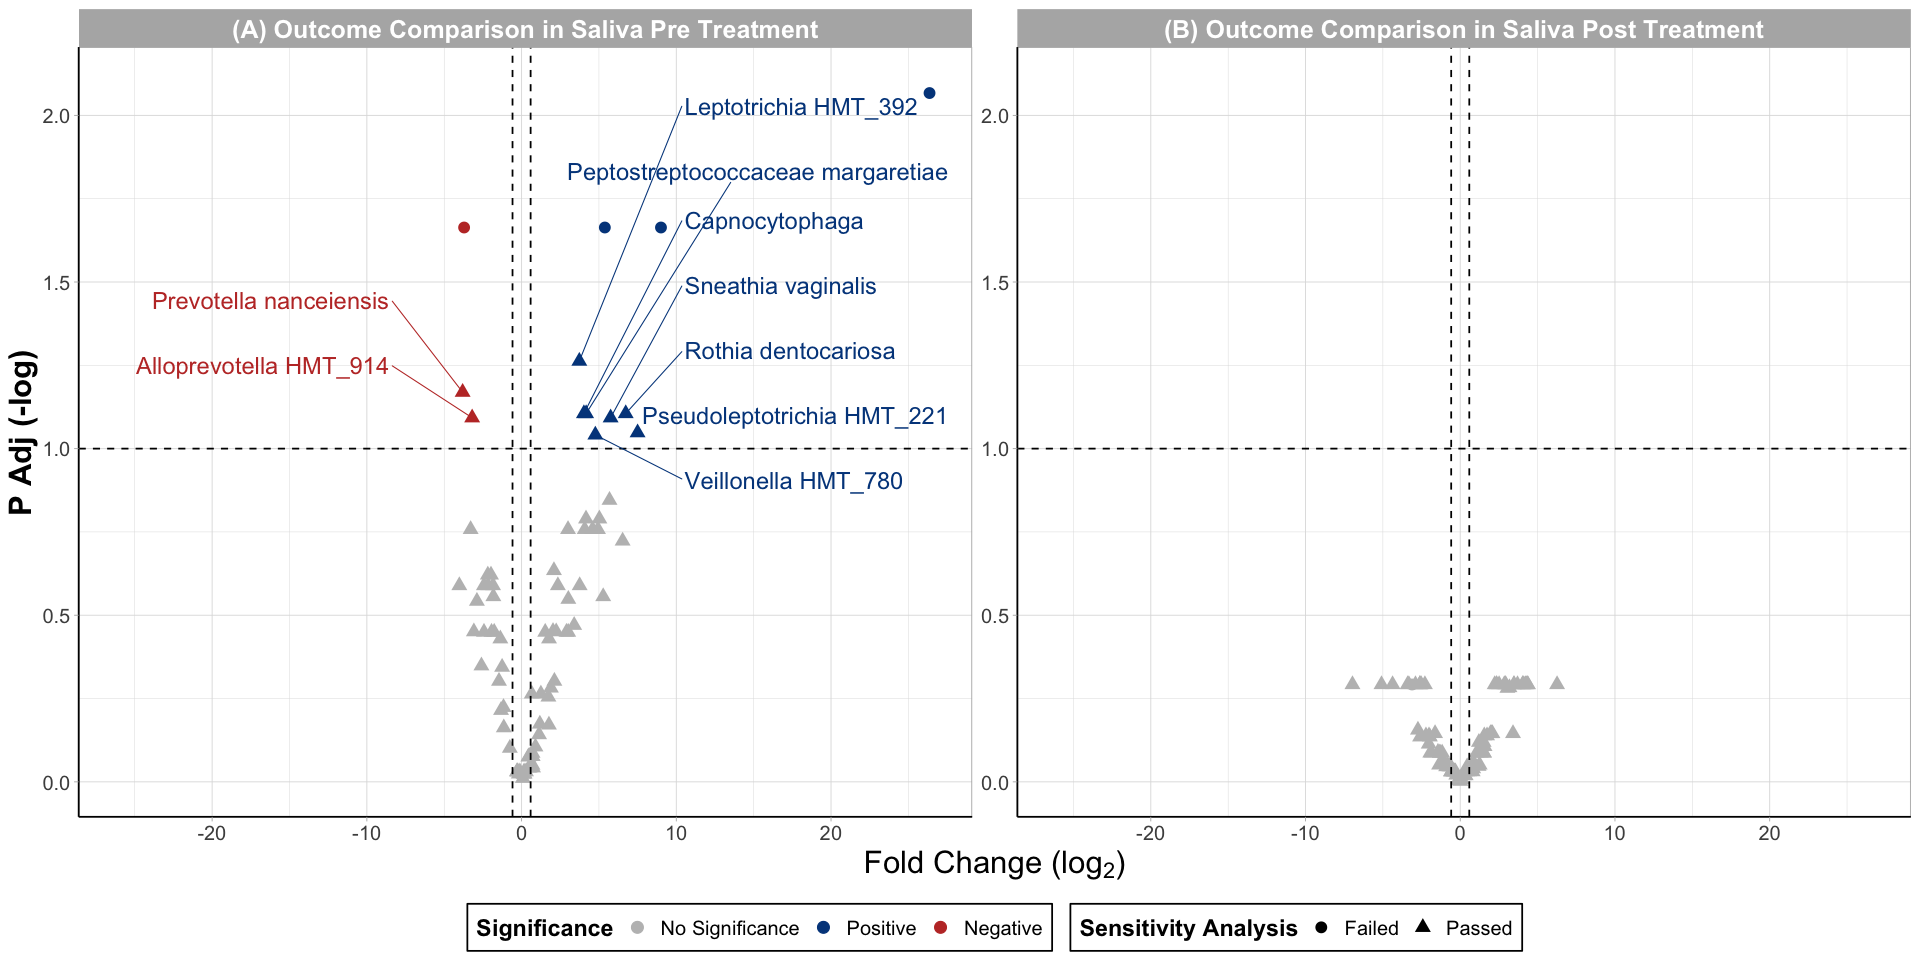

In [9]:
options(repr.plot.width=16, repr.plot.height=8) #changing size

lancet_palette = pal_lancet()(2)

Figure1 = ggplot() + 
  geom_point(data = saliva_time_point_df, aes(x = log2FC, y = -log10(P.Adj), color = diffexpressed,
                             shape = `Sensitivity Analysis`), size = 3) + 

  # P Value line
  geom_hline(yintercept = -log10(0.1), linetype = "dashed") + 
  # FC Line
  geom_vline(xintercept = log2(1.5), linetype = "dashed") +
  geom_vline(xintercept = -log2(1.5), linetype = "dashed") +

  # changing x limits of what is visible in the plot
    xlim(-26, 26.5) + 
    ylim(0, 2.1) + 

  geom_text_repel(data = saliva_time_point_df %>%
                  filter(log2FC > log2(1.5), P.Adj < 0.1, `Sensitivity Analysis` == "Passed",
                         Name %in% saliva_time_uncommon_bacteria), 
                  aes(x = log2FC, y = -log10(P.Adj), label = Name, color = diffexpressed), xlim = c(9, NA), 
                  hjust = 'right', direction = 'y', nudge_y = 0.3, nudge_x = 2,
                  segment.size = 0.3, box.padding = 1, max.overlaps = Inf, size = 5, show.legend = FALSE) + 

 geom_text_repel(data = saliva_time_point_df %>%
                  filter(log2FC < -log2(1.5), P.Adj < 0.1, `Sensitivity Analysis` == "Passed",
                         Name %in% saliva_time_uncommon_bacteria), 
                  aes(x = log2FC, y = -log10(P.Adj), label = Name, color = diffexpressed), 
                  hjust = 'left', direction = 'y', nudge_y = 0.21, nudge_x = -3, xlim = c(NA, -7), 
                 segment.size = 0.3, box.padding = 1, max.overlaps = Inf, size = 5, show.legend = FALSE) + 

  facet_wrap(~Model, scales = 'free') + 

  theme_light() + 
  theme(axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 14), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", # changing legend position
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        strip.text.x = element_text(size = 15, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 15, face = "bold")) + #changes size of facet y axis 
  labs(x = expression("Fold Change ("*log[2]*")"), y = 'P Adj (-log)') +

  scale_color_manual(name = "Significance",
                      values = c("gray", lancet_palette[1], '#C03830'))

Figure1

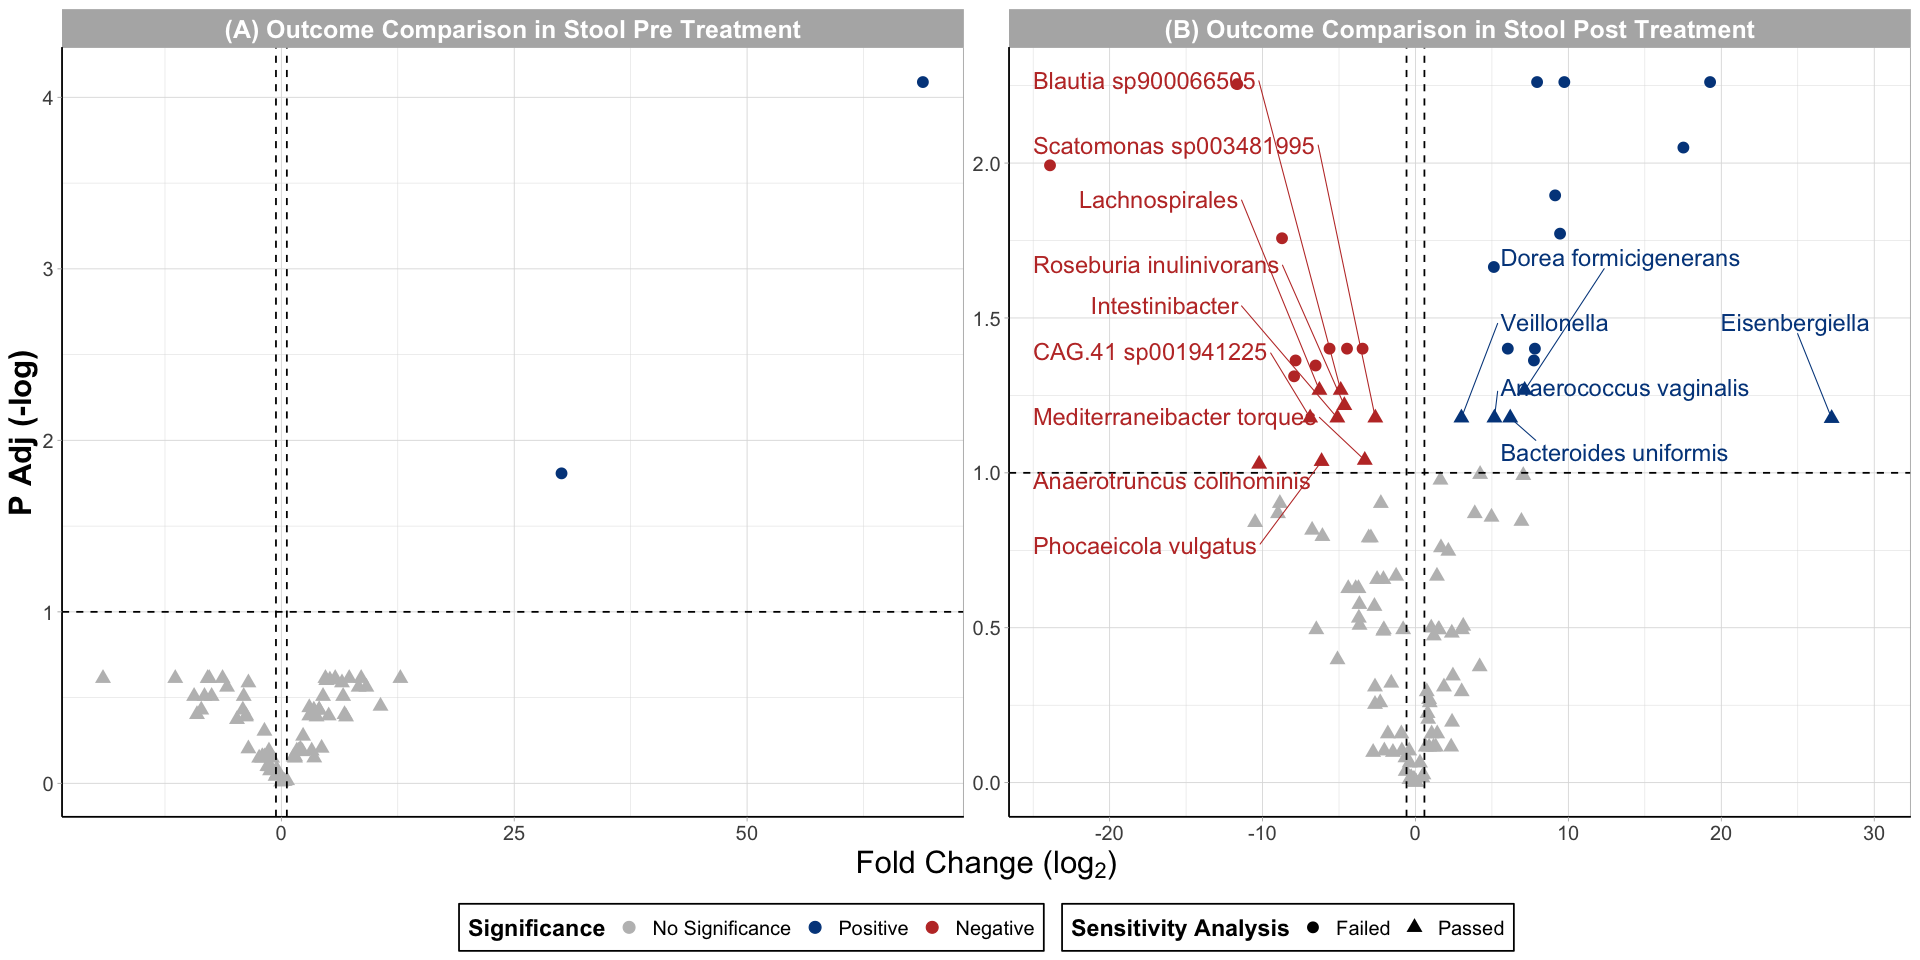

In [10]:
Figure2 = ggplot() + 
  geom_point(data = stool_time_point_df, aes(x = log2FC, y = -log10(P.Adj), color = diffexpressed,
                             shape = `Sensitivity Analysis`), size = 3) + 

  # P Value line
  geom_hline(yintercept = -log10(0.1), linetype = "dashed") + 
  # FC Line
  geom_vline(xintercept = log2(1.5), linetype = "dashed") +
  geom_vline(xintercept = -log2(1.5), linetype = "dashed") +

  # changing x limits of what is visible in the plot
    # xlim(-10, 10) + 
    # ylim(0, 2.2) + 

 #labeling points with statistical significance and FC

   geom_text_repel(data = stool_time_point_df %>%
                  filter(log2FC > log2(1.5), P.Adj < 0.1, `Sensitivity Analysis` == "Passed",
                         Name %in% stool_time_uncommon_bacteria), 
                  aes(x = log2FC, y = -log10(P.Adj), label = Name, color = diffexpressed), xlim = c(4, NA), 
                  hjust = 'right', direction = 'y', nudge_y = 0.24, nudge_x = 2.5,
                  segment.size = 0.3, box.padding = 1, max.overlaps = Inf, size = 5, show.legend = FALSE) + 
  geom_text_repel(data = stool_time_point_df %>%
                  filter(log2FC < -log2(1.5), P.Adj < 0.1, `Sensitivity Analysis` == "Passed",
                         Name %in% stool_time_uncommon_bacteria), 
                  aes(x = log2FC, y = -log10(P.Adj), label = Name, color = diffexpressed), xlim = c(NA, -10),
                  hjust = 'left', direction = 'y', nudge_y = 0.25, nudge_x = -4.3,
                 segment.size = 0.3, box.padding = 1, max.overlaps = Inf, size = 5, show.legend = FALSE) + 

  facet_wrap(~Model, scales = 'free') + 

  theme_light() + 
  theme(axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 14), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", # changing legend position
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        strip.text.x = element_text(size = 15, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 15, face = "bold")) + #changes size of facet y axis 
  labs(x = expression("Fold Change ("*log[2]*")"), y = 'P Adj (-log)') +

   scale_color_manual(name = "Significance",
                      values = c("gray", lancet_palette[1], '#C03830'))

Figure2

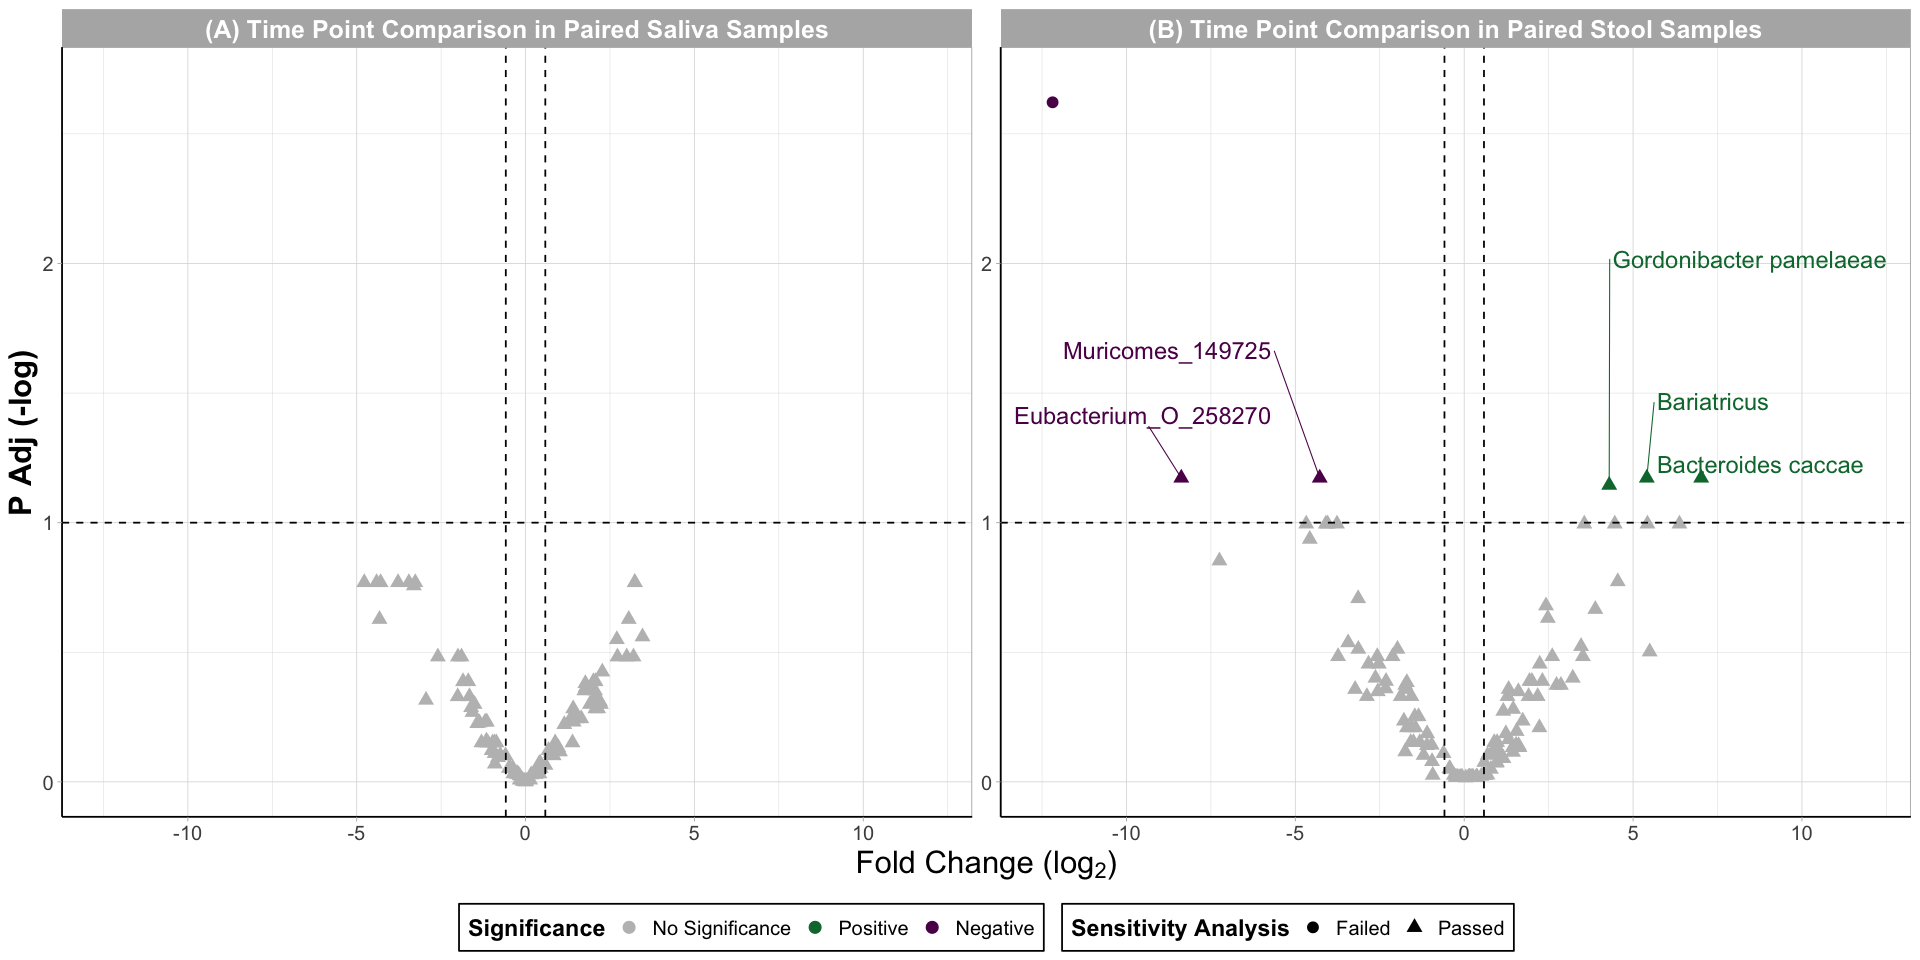

In [11]:
Figure3 = ggplot() + 
  geom_point(data = sig_paired_adj_df, aes(x = log2FC, y = -log10(P.Adj), color = diffexpressed,
                             shape = `Sensitivity Analysis`), size = 3) + 

  # P Value line
  geom_hline(yintercept = -log10(0.1), linetype = "dashed") + 
  # FC Line
  geom_vline(xintercept = log2(1.5), linetype = "dashed") +
  geom_vline(xintercept = -log2(1.5), linetype = "dashed") +

  # changing x limits of what is visible in the plot
    xlim(-12.5, 12) + 
    ylim(0, 2.7) + 

 #labeling points with statistical significance and FC
   geom_text_repel(data = sig_paired_adj_df %>%
                  filter(log2FC > log2(1.5), P.Adj < 0.1, `Sensitivity Analysis` == "Passed",
                         Name %notin% c(saliva_paired_common_bacteria, stool_paired_common_bacteria)), 
                  aes(x = log2FC, y = -log10(P.Adj), label = Name, color = diffexpressed), xlim = c(5, NA), 
                  hjust = 'right', direction = 'y', nudge_y = 0.65, nudge_x = 2.9,
                  segment.size = 0.3, box.padding = 1, max.overlaps = Inf, size = 5, show.legend = FALSE) + 

  geom_text_repel(data = sig_paired_adj_df %>%
                  filter(log2FC < -log2(1.5), P.Adj < 0.1, `Sensitivity Analysis` == "Passed",
                         Name %notin% c(saliva_paired_common_bacteria, stool_paired_common_bacteria)), 
                  aes(x = log2FC, y = -log10(P.Adj), label = Name, color = diffexpressed), xlim = c(NA, -5),
                   nudge_y = 0.3,# nudge_x = -0.05,
                 segment.size = 0.3, box.padding = 1, max.overlaps = Inf, size = 5, show.legend = FALSE) + 

  facet_wrap(~Model, scales = 'free') + 

  theme_light() + 
  theme(axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 14), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", # changing legend position
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        strip.text.x = element_text(size = 15, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 15, face = "bold")) + #changes size of facet y axis 
  labs(x = expression("Fold Change ("*log[2]*")"), y = 'P Adj (-log)') +

  scale_color_manual(name = "Significance",
                      values = c("gray", "#06763b", "#5c0558"))

Figure3

In [12]:
#exporting figure
ggsave(Figure1, 
       filename = 'Figure1.pdf',
       path = Output,
       width = 16, height = 8)
ggsave(Figure2, 
       filename = 'Figure2.pdf',
       path = Output,
       width = 16, height = 8)
ggsave(Figure3, 
       filename = 'Figure3.pdf',
       path = Output,
       width = 16, height = 8)